In [1]:
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import pickle
import nltk
import preprocessor as p


In [2]:

# importing the dataset
# DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
# dataset = pd.read_csv('./training.1600000.processed.noemoticon.csv', delimiter=',', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# dataset = pd.read_csv('./Corona_NLP_train.csv', delimiter=',', encoding=DATASET_ENCODING)
dataset = pd.read_csv('./IMDB Dataset.csv', delimiter=',', encoding=DATASET_ENCODING)

# removing the unnecessary columns and duplicates
# dataset = dataset[['OriginalTweet','Sentiment']]
dataset.drop_duplicates()

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# cleaning
# dataset['tweet'] = dataset['OriginalTweet'].apply(p.clean)
# dataset['sentiment'] = dataset['Sentiment']

dataset.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:

X = dataset['review']

y = dataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

X_train.shape, X_test.shape


((40000,), (10000,))

C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

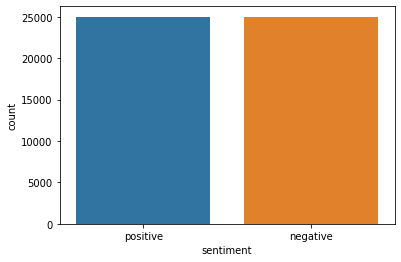

In [4]:
sns.countplot(y)

Text(0.5, 1.0, 'Positive words cloud')

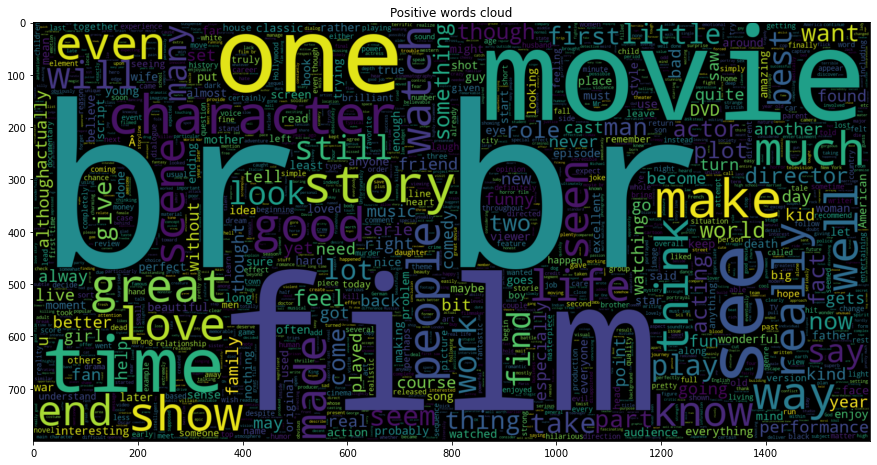

In [6]:
plt.figure(figsize = (15,15)) 
options = ['Positive', 'Extremely Positive', 'positive']
cond = dataset['sentiment'].isin(options)
result = dataset[cond].review.values
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(result))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Positive words cloud')

Text(0.5, 1.0, 'Negative words cloud')

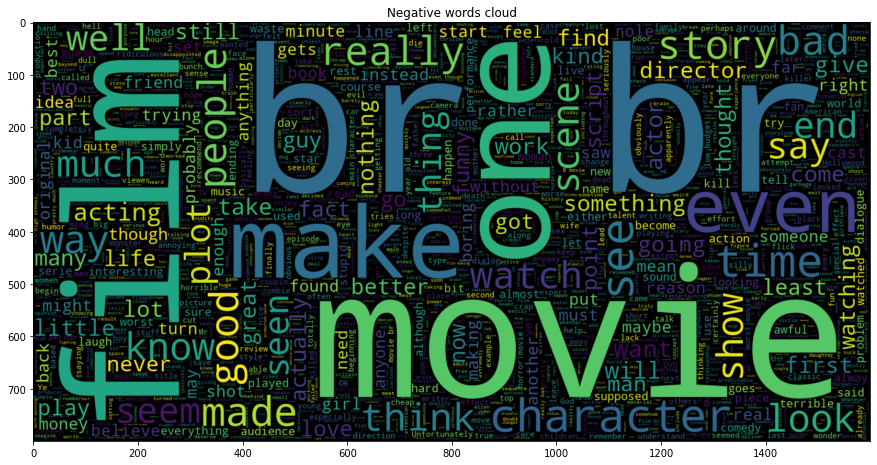

In [7]:
plt.figure(figsize = (15,15)) 
options = ['Negative', 'Extremely Negative', 'negative']
cond = dataset['sentiment'].isin(options)
result = dataset[cond].review.values
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(result))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Negative words cloud')

In [10]:

# creating our pipeline that will return an estimator
pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=20000, tokenizer=token.tokenize)), ('clf', MultinomialNB(alpha=1))])


In [11]:

parameters = {
    'tfidf__max_features': (10000, 20000),
    'tfidf__ngram_range': ((1,1), (1,2), (2,3)),
    'clf__fit_prior': (False,True),
    'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
    }

clf = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy', cv=5)

clf.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


                    precision    recall  f1-score   support

Extremely Negative       0.55      0.42      0.47      1083
Extremely Positive       0.53      0.50      0.51      1368
          Negative       0.43      0.50      0.46      1958
           Neutral       0.58      0.50      0.53      1538
          Positive       0.43      0.48      0.45      2285

          accuracy                           0.48      8232
         macro avg       0.50      0.48      0.49      8232
      weighted avg       0.49      0.48      0.48      8232



In [ ]:

print("Best: %f using %s" % (clf.best_score_, 
    clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.473106 using {'clf__alpha': 1, 'clf__fit_prior': False, 'tfidf__max_features': 20000}
0.467821 (0.003047) with: {'clf__alpha': 1, 'clf__fit_prior': False, 'tfidf__max_features': 10000}
0.473106 (0.003482) with: {'clf__alpha': 1, 'clf__fit_prior': False, 'tfidf__max_features': 20000}
0.446925 (0.003609) with: {'clf__alpha': 1, 'clf__fit_prior': True, 'tfidf__max_features': 10000}
0.430676 (0.002815) with: {'clf__alpha': 1, 'clf__fit_prior': True, 'tfidf__max_features': 20000}
0.461230 (0.002739) with: {'clf__alpha': 0.1, 'clf__fit_prior': False, 'tfidf__max_features': 10000}
0.463022 (0.002974) with: {'clf__alpha': 0.1, 'clf__fit_prior': False, 'tfidf__max_features': 20000}
0.468914 (0.003437) with: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__max_features': 10000}
0.467274 (0.003878) with: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__max_features': 20000}
0.460228 (0.004661) with: {'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__max_features': 10000}
0.454366

In [ ]:

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

In [ ]:

# exporting the pipeline
pickle.dump(pipeline['clf'], open('./models/MNB_model_', 'wb'))
pickle.dump(pipeline['tfidf'], open('./vector/tfidf_mnb_', 'wb'))